In [58]:
import numpy as np
import pandas as pd
import matplotlib
import cv2
import torchvision
import torch
from torch.autograd import Variable
from torch import Tensor, cat, sigmoid, exp, stack, max
from model import Darknet, Tail, Head

from weight_formater import darknet, tail

In [59]:
head = Head(Tensor([[116,90],  [156,198],  [373,326]]),80)
#head = Head(Tensor([[30,61],  [62,45],  [59,119]]),80)
#head = Head(Tensor([[10,13],  [16,30],  [33,23]]),80)

In [93]:
image = cv2.imread("/home/ivan/Desktop/BN-UQ280_FEDUCI_GR_20170810142213.jpg")
image = cv2.resize(image, (416, 416), interpolation=cv2.INTER_LINEAR)
image = image/255.0     
image = Variable(torch.from_numpy(image).float())
image = image.permute(2, 0, 1)

In [102]:
features = tail(darknet(image.unsqueeze(dim=0)))[0]

In [103]:
anchors=Tensor([[116,90],  [156,198],  [373,326]])
number_of_classes = 80
anchors = anchors.view(3, 1, 1, 2)

In [104]:
grid_size = list(features.size()[-2:])
cells_offsets = stack(meshgrid(linspace(0, 1 - 1 / grid_size[0], grid_size[0]),
                               linspace(0, 1 - 1 / grid_size[1], grid_size[1]).t()), -1)

In [105]:
features = features.view([-1, len(anchors), number_of_classes + 5] + grid_size) \
        .permute(0, 1, 3, 4, 2) \
        .contiguous()
        

In [106]:
centers = sigmoid(features[..., :2]) / Tensor(grid_size) + cells_offsets
sizes = exp(features[..., 2:4]) * anchors
probabilities = sigmoid(features[..., 4:])

In [118]:
probabilities.shape

torch.Size([1, 3, 13, 13, 81])

In [111]:
boxes = pd.DataFrame(centers.view(-1,2).detach().numpy(), columns=["center_x","center_y"])

In [115]:
boxes["width"]=0

In [119]:
boxes["obj"] = probabilities.view(-1,81)[...,0].detach().numpy()

In [120]:
boxes['height']=0

In [121]:
boxes[["width","height"]] = sizes.view(-1,2).detach().numpy()

In [124]:
boxes["obj"].max()

0.9980708

head(features)[0]

In [125]:
from src.boxes_manipulations import convert_to_matplotlib

In [126]:
import matplotlib.pyplot as plt

In [127]:
image = cv2.imread("/home/ivan/Desktop/BN-UQ280_FEDUCI_GR_20170810142213.jpg")
image = cv2.resize(image, (416, 416), interpolation=cv2.INTER_LINEAR)

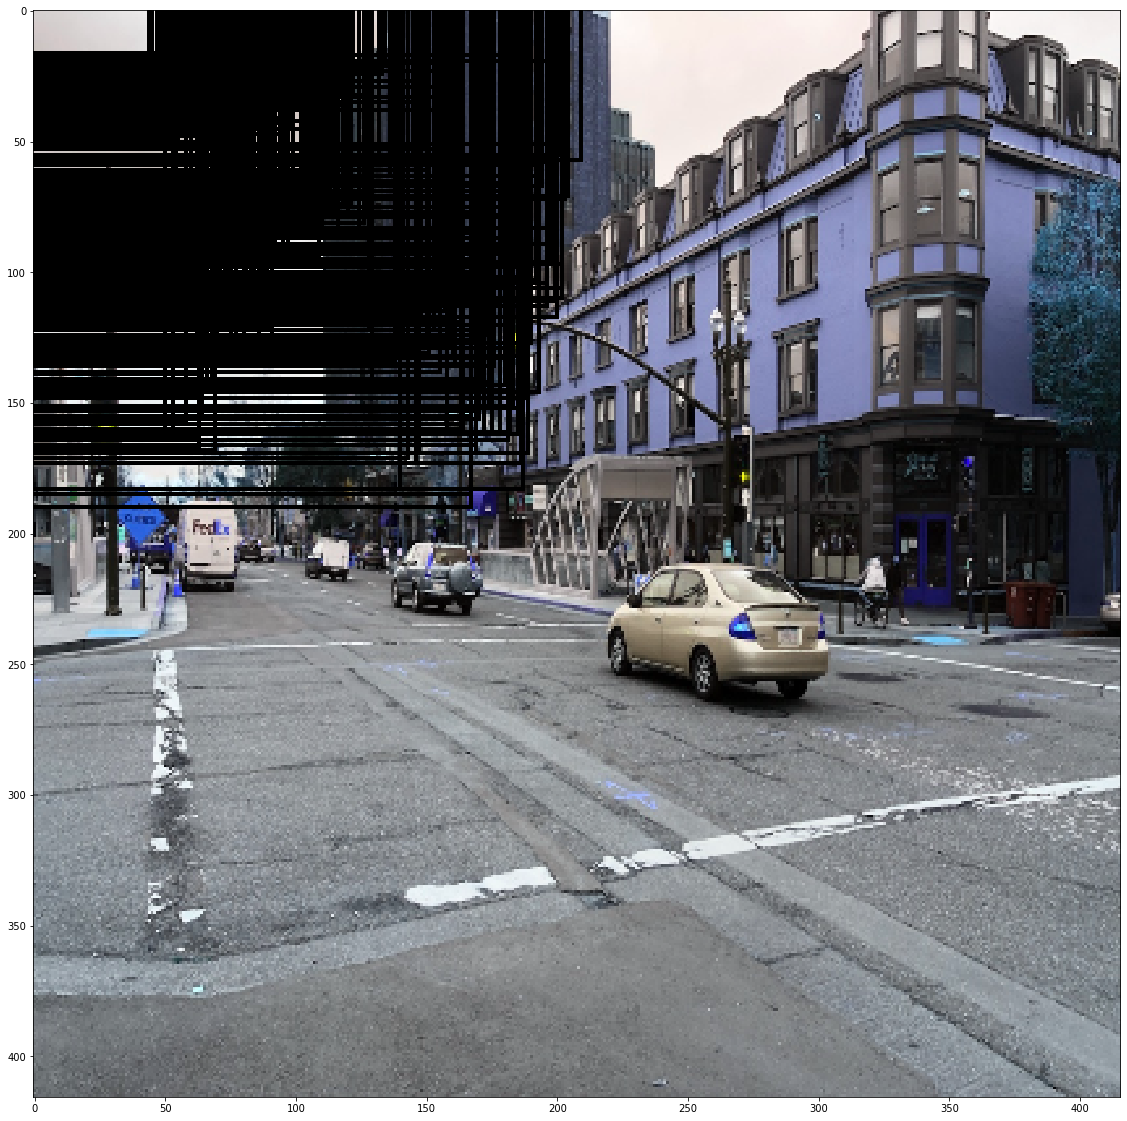

In [130]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)
for x,y, w, h in boxes[["center_x", "center_y","width", "height"]].values:
       ax.add_patch(plt.Rectangle((int(x-w/2), int(y-h/2)), int(w), int(h), linewidth=4, fill=False))
plt.imshow(image)
plt.show()